# **Relazione finale**

**Gruppo**: BigCovid

**Componenti del gruppo**: Alessio Verdolini, Federico Gaglio


1. **Analisi del dataset**

2. **Commons**

3. **Primo job**

  3.1 *MapReduce*
  
  3.2 *Hive*

  3.3 *Spark*

  3.4 *Risultati*

  3.5 *Grafici*
  

4. **Secondo job**

  4.1 *MapReduce*

  4.2 *Hive*

  4.3 *Spark*

  4.4 *Risultati*

  4.5 *Grafici*
  
5. **Terzo job**

  5.1 *MapReduce*

  5.2 *Hive*

  5.3 *Spark*

  5.4 *Risultati*

  5.5 *Grafici*

## 1. Analisi del dataset

## 2. Commons

### 2.1 Grafici


In [0]:
import matplotlib
import matplotlib.pyplot as plt
import csv

CSV_PATH='time-execute/'


def draw_plot(job_number):
    LOCAL = CSV_PATH+'local_'+str(job_number)+'.csv'
    CLUSTER = CSV_PATH+'cluster_'+str(job_number)+'.csv'
    
    dataset={}
    data_local = {}
    data_cluster = {}
    
    with open(LOCAL,'r') as csvfile:
        plots = csv.reader(csvfile, delimiter=',')
        for row in plots:
            job, *times=row
            data_local[job]=[float(x) for x in times]
        dataset[0] = {
            'name': "Locale",
            'time': data_local
        }
    
    with open(CLUSTER,'r') as csvfile:
        plots = csv.reader(csvfile, delimiter=',')
        for row in plots:
            job, *times=row
            data_cluster[job]=[float(x) for x in times]
        dataset[1] = {
            'name': "Cluster",
            'time': data_cluster
        }
        
    plot, axs = plt.subplots(1, 2, figsize=(15, 5))

    for i in range(0,2):
        axs[i].plot(dataset[i]['time']['dim'], dataset[i]['time']['1'], color='tab:blue', marker='o')
        axs[i].plot(dataset[i]['time']['dim'], dataset[i]['time']['2'], color='tab:orange', marker='o')
        axs[i].plot(dataset[i]['time']['dim'], dataset[i]['time']['3'], color='tab:green', marker='o')
        
        axs[i].set_title(dataset[i]['name'])
        axs[i].set_xlabel('Dimensione (MB)')
        axs[i].set_ylabel('Tempo (s)')
        axs[i].grid(alpha=0.4)
        axs[i].legend(['MapReduce', 'Hive', 'Spark'])

## 3. Primo job

### 3.1 Map Reduce

Un job che sia in grado di generare le statistiche di ciascuna azione tra il 2008 e il 2018 indicando, per ogni azione: (a) il simbolo, (b) la variazione della quotazione (differenza percentuale arrotondata tra i prezzi di chiusura iniziale e finale dell’intervallo temporale), (c) il prezzo minimo, (e) quello massimo e (f) il volume medio nell’intervallo, ordinando l’elenco in ordine decrescente di variazione della quotazione.

**Config**

Usiamo campi come chiavi: *ticker* come chiave primaria usata per aggregare 
 i dati da passare al reducer e *date* per effettuare l'ordinamento secondario sui valori delle date.

In [0]:
-D stream.num.map.output.key.fields=2 
-D mapreduce.job.reduces=1 

**Mapper**


In fase di mapping estraiamo da ciascun record i campi *ticker*, *date*, *close*, *volume*.

In [0]:
#PSEUDO MAPPER

class Mapper:

  for line in file.csv

    extract ticker, close, volume, date from file.csv
    
    if year in (2008, 2018)
      send to reducer ticker, data, close, volume

**Reducer**

In fase di reducing, dopo aver estratto i valori passati dal mapper, andiamo a calcolare i punti definiti nell'hw; in particolare per il calcolo del volume abbiamo creato un oggetto(avgVolume) per semplificarci il calcolo.

In [0]:
#PSEUDO REDUCER

class Reducer:
  
  define AvgVolume object

  for line in mapper output

    extract ticker, year, close, volume

    percentageChange = ((close_price_final_value - close_price_starting_value) / close_price_starting_value) * 100
    minLowPrice = min(close)
    maxHighPrice = max(close)
    avgVolume = avg(volume)
    
    sorting values based on percentageChange key

### 3.2 Hive

**Implementazione Hive**

---

```
ticker_min_max_avg(ticker, min_price, max_price, avg_volume) 
```

>**min_price:** *Valore minimo di chiusura*
<br>
>**max_price:** *Valore massimo di chiusura*
<br>
>**avg_volume:** *Volume medio nell'intervallo*

<br>

```
ticker_min_max_data(ticker, min_data, max_data) 
```

>**min_data:** *La prima data in cui è stato quotato il ticker*
<br>
>**max_data:** *L'ultima data in cui è stato quotato il ticker*

<br>

```
ticker_close_min_data(ticker, data, min_price) 
```
>**min_price**: *Valore iniziale di chiusura*

<br>

```
ticker_close_max_data(ticker, data, max_price) 
```
>**max_price**: *Valore finale di chiusura*

<br>

```
ticker_percentuale(ticker, inc_perc) 
```
>**inc_perc**: *Variazione di quotazione (((max_price-min_price)/min_price)x100)*


```sql
CREATE TABLE IF NOT EXISTS ticker_min_max_avg AS 
SELECT ticker, min(close) AS min_price, max(close) AS max_price, avg(volume) AS avg_volume 
FROM historical_stock_prices 
WHERE YEAR(data)>=2008 AND YEAR(data)<=2018 
GROUP BY ticker;

CREATE TABLE IF NOT EXISTS ticker_min_max_data AS 
SELECT ticker, min(TO_DATE(data)) AS min_data, max(TO_DATE(data)) AS max_data
FROM historical_stock_prices 
WHERE YEAR(data)>=2008 AND YEAR(data)<=2018 
GROUP BY ticker;

CREATE TABLE IF NOT EXISTS ticker_close_min_data AS 
SELECT h.ticker, h.data, h.close AS min_price
FROM ticker_min_max_data AS t
JOIN historical_stock_prices AS h 
ON h.ticker=t.ticker AND h.data=t.min_data;

CREATE TABLE IF NOT EXISTS ticker_close_max_data AS 
SELECT h.ticker, h.data, h.close AS max_price
FROM ticker_min_max_data AS t
JOIN historical_stock_prices AS h 
ON h.ticker=t.ticker AND h.data=t.max_data;

CREATE TABLE IF NOT EXISTS ticker_percentuale AS 
SELECT mi.ticker, (((ma.max_price-mi.min_price)/mi.min_price) * 100) AS inc_perc 
FROM ticker_close_max_data AS ma
JOIN ticker_close_min_data AS mi
ON ma.ticker=mi.ticker;

CREATE TABLE IF NOT EXISTS result_job_1 AS 
SELECT t.ticker, p.inc_perc, t.min_price, t.max_price, t.avg_volume 
FROM ticker_min_max_avg AS t
JOIN ticker_percentuale AS p
ON t.ticker=p.ticker 
ORDER BY p.inc_perc DESC limit 10;
```

### 3.3 Spark

**Implementazione Spark**

In fase di mapping estrapoliamo innanzitutto da ciascun record i campi ticker, close, low, high, volume e date.
Successivamente verifichiamo che il record sia relativo ad un anno che ricada nell'intervallo 1998-2018, per poi stampare la chiave i valori associati alla chiave. In particolare la chiave è composta da due campi: ticker, usata come chiave "primaria", e date usata come chiave "secondaria".
In questo modo valori che verranno ricevuti dal reducer saranno aggregati per il solo campo ticker e ordinati in base al campo date (si parla in questo caso di secondary sort). Questo consentirà nella fase di reduce di evitare comparazioni tra date (per trovare la data più recente e quella meno recente) ai fini del calcolo della differenza percentuale.
Il valore associato alla chiave è invece composto dai campi close, low, high e volume.

In [0]:
#!/usr/bin/env python
import sys

# constant for fields position
TICKER = 0
DATE = 1
CLOSE = 2
VOLUME = 3
  

### 3.4 Risultati



Si mostra ora l'output restituito per il primo job:


```
Ticker Percent Change Min low          Max high	   Average volume
MNST  163340.387616%  0.0305979158729  70.2200012207  7347898.8208
AMZN  38328.032677%   4.14583349228    1925.0         7868702.73287
AAPL  37146.0319467%  0.482142865658   219.179992676  121398558.199
CTSH  36312.8011611%  0.145833328366   85.0999984741  6272137.93307
CELG  24924.0000849%  0.171875         147.169998169  8002695.57352
WP    24012.4988778%  0.0500000007451  96.5100021362  1270066.16934
MED   13733.2303561%  0.0936999991536  229.199996948  223768.309139
NVR   11786.7001488%  21.625           3700.0         56463.7413395
ANSS  10077.1432059%  1.375            184.949996948  482841.405197
TSCO  9508.67816472%  0.40625          97.25          1592298.53705
```

### 3.5 Grafici

In [0]:
draw_plot(1)

## 4. Secondo job

### 4.1 Map Reduce

Un job che sia in grado di generare, per ciascun settore, il relativo “trend” nel periodo 2008-2018 ovvero un elenco contenete, per ciascun anno nell’intervallo: (a) il volume annuale1 medio delle azioni del settore, (b) la variazione annuale2 media delle aziende del settore e (c) la quotazione giornaliera media delle aziende del settore.

**Config**




In [0]:
-D stream.num.map.output.key.fields=3 
-D mapreduce.partition.keypartitioner.options=-k1,1 
-D mapreduce.job.reduces=1 
-partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner

**Mapper**

In fase di mapping andiamo a estrarre da due file differenti i record di interesse. In particolare dal file caricato su Hadoop estraiamo i campi *ticker*, *close*, *volume*, *date*, mentre dal file che leggiamo direttamente dal nostro IDE estraiamo i campi *ticker* e *sector*.
Le chiavi che vengono usate in questo secondo job sono 3: *sector*, *ticker* e *date*.


In [0]:
#PSEUDO MAPPER

class Mapper:

  extract ticker, sector from localFile

  for line in input
    extract ticker, close, volume, date

    if year in (2008,2018)
      send to reducer sector, ticker, date, close, volume

**Reducer**

In fase di reducing, dopo aver estratto i valori passati dal mapper, andiamo a calcolare i punti definiti nell'hw; in particolare per il calcolo dei dati di interesse siamo andati a definire 3 oggetti differenti.

In [0]:
#definizione oggetti usati

class AverageObject:

    #fields
    value
    count

    #method
    def add(value):
        value += value
        count += 1

    def avg():
        return (value / count)



class Record:

    #fields
    avg_year_volume = AverageObject()
    avg_year_change_company = AverageObject()
    avg_daily_price = AverageObject()

    #method
    def add_volume(volume):
        avg_year_volume.add(volume)

    def add_year_change(year_change):
        avg_year_change_company.add(year_change)

    def add_daily_price(daily_price):
        avg_daily_price.add(daily_price)



class Sector:

  #fields
  name
  year_2_record = {
      key: year, 
      value: Record()
  }

  #method
  def update(year, volume, year_change, daily_price):    
    year_2_record[year].add_volume(volume)
    year_2_record[year].add_year_change(year_change)
    year_2_record[year].add_daily_price(daily_price) 

In [0]:
#PSEUDO REDUCER

class Reducer:

  #TODO
  

### 4.2 Hive

**Implementazione Hive**

---

```
ticker_data_volume(sector, ticker, anno, sum_volume) 
```

>**sum_volume**: *Volume totale di un ticker*

<br>

```
sector_data_volume(sector, anno, avg_volume ) 
```

>**avg_volume**: *Volume annuale medio delle azioni del settore*

<br>

```
sector_data_min_max(sector, ticker, min_data, max_data) 
```

>**min_data**: *La prima data in cui è stato quotato il ticker*
<br>
>**max_data**: *L'ultima data in cui è stato quotato il ticker*

<br>
 
```
ticker_close_min_data(sector, ticker, data, min_price) 
```

>**min_price**: *Primo valore di chiusura*

<br>
 
```
ticker_close_max_data(sector, ticker, data, max_price) 
```

>**max_price**: *Ultimo valore di chiusura*

<br>

```
ticker_percentuale(sector, ticker, anno, inc_perc) 
```

>**inc_perc**: *Variazione della quotazione (((max_price-min_price)/min_price)x100)*

<br>

```
sector_avg_percentuale(sector, anno, avg_perc) 
```

>**avg_perc**: *La variazione annuale media delle aziende del settore*

<br>

```
ticker_avg_price(sector, ticker, anno, avg_ticker_price) 
```

>**avg_ticker_price**: *La quotazione giornaliera media del ticker in un anno*

<br>
 
```
sector_avg_price(sector, anno, avg_sector_price) 
```

>**avg_sector_price**: *La quotazione giornaliera media delle aziende del settore in un anno*


```sql
CREATE TABLE IF NOT EXISTS first_pricipal_table AS 
SELECT hs.sector, hsp.ticker, hsp.data, hsp.close, hsp.volume 
FROM historical_stock AS hs 
JOIN historical_stock_prices AS hsp 
ON hsp.ticker=hs.ticker 
WHERE YEAR(hsp.data)>=2008 AND YEAR(hsp.data)<=2018 
AND hs.sector!='N/A';

CREATE TABLE IF NOT EXISTS ticker_data_volume AS 
SELECT sector, ticker, YEAR(data) AS anno, SUM(volume) AS sum_volume 
FROM first_pricipal_table 
GROUP BY sector, ticker, YEAR(data);

--sector_data_volume
CREATE TABLE IF NOT EXISTS sector_data_volume AS 
SELECT sector, anno, AVG(sum_volume) AS avg_volume 
FROM ticker_data_volume 
GROUP BY sector, anno;


CREATE TABLE IF NOT EXISTS sector_data_min_max AS 
SELECT sector, ticker, min(TO_DATE(data)) AS min_data, max(TO_DATE(data)) AS max_data 
FROM first_pricipal_table 
GROUP BY sector, ticker, YEAR(data);

CREATE TABLE IF NOT EXISTS ticker_close_min_data AS 
SELECT t.sector, h.ticker, h.data, h.close AS min_price
FROM sector_data_min_max AS t
JOIN historical_stock_prices AS h 
ON h.ticker=t.ticker AND h.data=t.min_data;

CREATE TABLE IF NOT EXISTS ticker_close_max_data AS 
SELECT t.sector, h.ticker, h.data, h.close AS max_price
FROM sector_data_min_max AS t
JOIN historical_stock_prices AS h 
ON h.ticker=t.ticker AND h.data=t.max_data;


CREATE TABLE IF NOT EXISTS ticker_percentuale AS 
SELECT mi.sector, mi.ticker, YEAR(mi.data) as anno, (((ma.max_price-mi.min_price)/mi.min_price) * 100) AS inc_perc 
FROM ticker_close_max_data AS ma
JOIN ticker_close_min_data AS mi
ON ma.ticker=mi.ticker AND YEAR(ma.data)=YEAR(mi.data);

--sector_avg_percentuale
CREATE TABLE IF NOT EXISTS sector_avg_percentuale AS 
SELECT sector, anno, AVG(inc_perc) AS avg_perc
FROM ticker_percentuale
GROUP BY sector, anno;

CREATE TABLE IF NOT EXISTS ticker_avg_price AS
SELECT sector, ticker, YEAR(data) AS anno, AVG(close) AS avg_ticker_price
FROM first_pricipal_table
GROUP BY sector, ticker, YEAR(data);

--sector_avg_price
CREATE TABLE IF NOT EXISTS sector_avg_price AS
SELECT sector, anno, AVG(avg_ticker_price) AS avg_sector_price
FROM ticker_avg_price
GROUP BY sector, anno;


CREATE TABLE IF NOT EXISTS result_job_2 AS 
SELECT a.sector, a.anno, a.avg_volume, b.avg_perc, c.avg_sector_price 
FROM sector_data_volume AS a
JOIN sector_avg_percentuale AS b
JOIN sector_avg_price AS c 
ON a.sector=b.sector AND b.sector=c.sector AND a.anno=b.anno AND b.anno=c.anno
ORDER BY sector, anno;

```

### 4.3 Spark

**Implementazione Spark**

In fase di mapping estrapoliamo innanzitutto da ciascun record i campi ticker, close, low, high, volume e date.
Successivamente verifichiamo che il record sia relativo ad un anno che ricada nell'intervallo 1998-2018, per poi stampare la chiave i valori associati alla chiave. In particolare la chiave è composta da due campi: ticker, usata come chiave "primaria", e date usata come chiave "secondaria".
In questo modo valori che verranno ricevuti dal reducer saranno aggregati per il solo campo ticker e ordinati in base al campo date (si parla in questo caso di secondary sort). Questo consentirà nella fase di reduce di evitare comparazioni tra date (per trovare la data più recente e quella meno recente) ai fini del calcolo della differenza percentuale.
Il valore associato alla chiave è invece composto dai campi close, low, high e volume.

In [0]:
#!/usr/bin/env python
import sys

# constant for fields position
TICKER = 0
DATE = 1
CLOSE = 2
VOLUME = 3
  

### 4.4 Risultati



Si mostra ora l'output restituito per il primo job:


```
Ticker Percent Change Min low          Max high	   Average volume
MNST  163340.387616%  0.0305979158729  70.2200012207  7347898.8208
AMZN  38328.032677%   4.14583349228    1925.0         7868702.73287
AAPL  37146.0319467%  0.482142865658   219.179992676  121398558.199
CTSH  36312.8011611%  0.145833328366   85.0999984741  6272137.93307
CELG  24924.0000849%  0.171875         147.169998169  8002695.57352
WP    24012.4988778%  0.0500000007451  96.5100021362  1270066.16934
MED   13733.2303561%  0.0936999991536  229.199996948  223768.309139
NVR   11786.7001488%  21.625           3700.0         56463.7413395
ANSS  10077.1432059%  1.375            184.949996948  482841.405197
TSCO  9508.67816472%  0.40625          97.25          1592298.53705
```

### 4.5 Grafici

In [0]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
t = np.arange(0.0, 2.0, 0.01)
s = 1 + np.sin(2 * np.pi * t)

fig, ax = plt.subplots()
ax.plot(t, s)

ax.set(xlabel='time (s)', ylabel='voltage (mV)',
       title='About as simple as it gets, folks')
ax.grid()

fig.savefig("test.png")
plt.show()

## 5. Terzo job

### 5.1 Map Reduce

Un job in grado di generare gruppi di aziende le cui azioni hanno avuto lo stesso trend in termini di variazione annuale nell’ultimo triennio disponibile, indicando le aziende e il trend comune (es. {Apple, Intel, Amazon}: 2016:-1%, 2017:+3%, 2018:+5%).

**Config**




In [0]:
#Prima passata
    
-D stream.num.map.output.key.fields=2
-D mapreduce.partition.keypartitioner.options=-k1,1
-D mapreduce.job.reduces=1
-partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner


In [0]:
#Seconda passata

-D stream.num.map.output.key.fields=3
-D mapreduce.job.reduces=1

**Mapper 1**


In fase di mapping andiamo a estrarre da due file differenti i record di interesse. In particolare dal primo estraiamo i campi *ticker*, *close*, *date*, mentre dal secondo estraiamo i campi *ticker* e *name*.
Le chiavi che vengono usate in questo secondo job sono 2: *sector*, *date*.

In [0]:
#PSEUDO MAPPER1

class Mapper:

  extract ticker, name from localFile

  for line in input
    extract ticker, close, date

    if year in (2016,2018)
      send to reducer1 ticker, date, close, name


**Reducer 1**

In fase di reducing, dopo aver estratto i valori passati dal mapper, andiamo a calcolare i punti definiti nell'hw; in particolare per il calcolo del volume abbiamo creato un oggetto(avgVolume) per semplificarci il calcolo.

In [0]:
#PSEUDO REDUCER 1

#TODO


**Mapper 2**

Questo secondo mapper l'unica cosa che va a fare è leggere l'output del primo reducer da Hadoop e lo va a passare al secondo reducer

In [0]:
for line in input
  send line to reducer2 

**Reducer 2**

In fase di reducing, dopo aver estratto i valori passati dal mapper2, andiamo a calcolare i punti definiti nell'hw; in particolare per il calcolo del volume abbiamo creato un oggetto(avgVolume) per semplificarci il calcolo.

In [0]:
#PESUDO REDUCER2

#todo


### 5.2 Hive

**Implementazione Hive**

---

```
sector_data_min_max(name, ticker, min_data, max_data ) 
```

>**min_data**: **
<br>
>**max_price**: **

<br>

```
ticker_close_min_data(name, ticker, data, min_price) 
```

>min_price:

<br>

```
ticker_close_max_data(name, ticker, data, max_price) 
```

>max_price:

<br>

```
ticker_percentuale(name, ticker, anno, inc_perc ) 
```

>inc_perc:

<br>


CREATE TABLE IF NOT EXISTS first_year AS 
SELECT name, inc_perc
FROM ticker_percentuale
WHERE anno == 2016
ORDER BY name;

CREATE TABLE IF NOT EXISTS second_year AS 
SELECT name, inc_perc
FROM ticker_percentuale
WHERE anno == 2017
ORDER BY name;

CREATE TABLE IF NOT EXISTS third_year AS 
SELECT name, inc_perc
FROM ticker_percentuale
WHERE anno == 2018
ORDER BY name;

```sql
CREATE TABLE IF NOT EXISTS first_pricipal_table AS 
SELECT hs.name, hsp.ticker, hsp.data, hsp.close
FROM historical_stock AS hs 
JOIN historical_stock_prices AS hsp 
ON hsp.ticker=hs.ticker 
WHERE YEAR(hsp.data)>=2016 AND YEAR(hsp.data)<=2018 
AND hs.name!='N/A';

CREATE TABLE IF NOT EXISTS sector_data_min_max AS 
SELECT name, ticker, min(TO_DATE(data)) AS min_data, max(TO_DATE(data)) AS max_data 
FROM first_pricipal_table 
GROUP BY name, ticker, YEAR(data);

CREATE TABLE IF NOT EXISTS ticker_close_min_data AS 
SELECT t.name, h.ticker, h.data, h.close AS min_price
FROM sector_data_min_max AS t
JOIN historical_stock_prices AS h 
ON h.ticker=t.ticker AND h.data=t.min_data;

CREATE TABLE IF NOT EXISTS ticker_close_max_data AS 
SELECT t.name, h.ticker, h.data, h.close AS max_price
FROM sector_data_min_max AS t
JOIN historical_stock_prices AS h 
ON h.ticker=t.ticker AND h.data=t.max_data;


CREATE TABLE IF NOT EXISTS ticker_percentuale AS 
SELECT mi.name, mi.ticker, YEAR(mi.data) as anno, (((ma.max_price-mi.min_price)/mi.min_price) * 100) AS inc_perc 
FROM ticker_close_max_data AS ma
JOIN ticker_close_min_data AS mi
ON ma.ticker=mi.ticker AND YEAR(ma.data)=YEAR(mi.data);


CREATE TABLE IF NOT EXISTS first_year AS 
SELECT name, inc_perc
FROM ticker_percentuale
WHERE anno == 2016
ORDER BY name;

CREATE TABLE IF NOT EXISTS second_year AS 
SELECT name, inc_perc
FROM ticker_percentuale
WHERE anno == 2017
ORDER BY name;

CREATE TABLE IF NOT EXISTS third_year AS 
SELECT name, inc_perc
FROM ticker_percentuale
WHERE anno == 2018
ORDER BY name;

CREATE TABLE IF NOT EXISTS res AS
SELECT first_year.name, first_year.inc_perc AS primo, second_year.inc_perc AS secondo, third_year.inc_perc AS terzo
FROM first_year, second_year, third_year
WHERE first_year.name = second_year.name AND second_year.name = third_year.name
ORDER BY primo, secondo, terzo;

```

### 5.3 Spark

**Implementazione Spark**

In fase di mapping estrapoliamo innanzitutto da ciascun record i campi ticker, close, low, high, volume e date.
Successivamente verifichiamo che il record sia relativo ad un anno che ricada nell'intervallo 1998-2018, per poi stampare la chiave i valori associati alla chiave. In particolare la chiave è composta da due campi: ticker, usata come chiave "primaria", e date usata come chiave "secondaria".
In questo modo valori che verranno ricevuti dal reducer saranno aggregati per il solo campo ticker e ordinati in base al campo date (si parla in questo caso di secondary sort). Questo consentirà nella fase di reduce di evitare comparazioni tra date (per trovare la data più recente e quella meno recente) ai fini del calcolo della differenza percentuale.
Il valore associato alla chiave è invece composto dai campi close, low, high e volume.

In [0]:
#!/usr/bin/env python
import sys

# constant for fields position
TICKER = 0
DATE = 1
CLOSE = 2
VOLUME = 3
  

### 5.4 Risultati



Si mostra ora l'output restituito per il primo job:


```
Ticker Percent Change Min low          Max high	   Average volume
MNST  163340.387616%  0.0305979158729  70.2200012207  7347898.8208
AMZN  38328.032677%   4.14583349228    1925.0         7868702.73287
AAPL  37146.0319467%  0.482142865658   219.179992676  121398558.199
CTSH  36312.8011611%  0.145833328366   85.0999984741  6272137.93307
CELG  24924.0000849%  0.171875         147.169998169  8002695.57352
WP    24012.4988778%  0.0500000007451  96.5100021362  1270066.16934
MED   13733.2303561%  0.0936999991536  229.199996948  223768.309139
NVR   11786.7001488%  21.625           3700.0         56463.7413395
ANSS  10077.1432059%  1.375            184.949996948  482841.405197
TSCO  9508.67816472%  0.40625          97.25          1592298.53705
```

### 5.5 Grafici

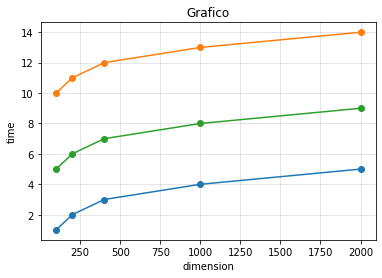

In [0]:
import matplotlib
import matplotlib.pyplot as plt
import csv

jd = {}

CSV_PATH='time-execute/'
CSV_FILE='local.csv'

with open(CSV_PATH+CSV_FILE,'r') as csvfile:
    plots = csv.reader(csvfile, delimiter=',')
    for row in plots:
        job, *times=row
        jd[job]=[float(x) for x in times]

plt.plot(jd['job'], jd['1'], color='tab:blue', marker='o')
plt.plot(jd['job'], jd['2'], color='tab:orange', marker='o')
plt.plot(jd['job'], jd['3'], color='tab:green', marker='o')
plt.title('Grafico')
plt.xlabel('dimension')
plt.ylabel('time')
plt.grid(alpha=0.4)